This notebook contains the necessary scripts for making the base case model.

In [1]:
### Starting with the import of the necessary libraries:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import scipy
from scipy.stats import linregress
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

C:\Users\po7517\Anaconda3\envs\new_env\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\po7517\Anaconda3\envs\new_env\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
C:\Users\po7517\Anaconda3\envs\new_env\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
### either CPU or GPU:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [3]:
### Reading the dummy data
all_data = pd.read_csv('data/all_data_dummy.csv')

In [7]:
def pytorch_NN(all_data, input_features, target_variables, weight_decay=1e-3, patience=100):
    
    '''
    This function reads the data and based on the interest of the user, different 
    input features and target variables can be selected from the existing measured
    parameters.
    weight_decay is a regularization technique used to prevent overfitting by penalizing 
    large weights in the model. More details at 
    https://pytorch.org/docs/stable/generated/torch.optim.Adam.html
    patience refers to the number of training epochs to wait after the last improvement 
    in the monitored metric (e.g., validation loss, accuracy) before stopping the training process.
    More details at https://pytorch.org/ignite/generated/ignite.handlers.early_stopping.EarlyStopping.html
    '''
    
    # Extract and split data
    X = all_data[input_features].to_numpy()
    y = all_data[target_variables].to_numpy()
    
    # Split: 60% train, 20% val, 20% test
    X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2)
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25)  # 0.25 * 0.8 = 0.2

    # Normalize
    scaler_x = RobustScaler()
    scaler_y = RobustScaler()
    X_train_norm = scaler_x.fit_transform(X_train)
    X_val_norm = scaler_x.transform(X_val)
    X_test_norm = scaler_x.transform(X_test)
    y_train_norm = scaler_y.fit_transform(y_train)
    y_val_norm = scaler_y.transform(y_val)
    y_test_norm = scaler_y.transform(y_test)

    # Convert to tensors
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    XX = torch.from_numpy(X_train_norm.astype(np.float32)).to(device)
    yy = torch.from_numpy(y_train_norm.astype(np.float32)).to(device)
    XX_val = torch.from_numpy(X_val_norm.astype(np.float32)).to(device)
    yy_val = torch.from_numpy(y_val_norm.astype(np.float32)).to(device)

    # Define model
    class NN(nn.Module):
        def __init__(self, input_dim, output_dim):
            super(NN, self).__init__()
            self.fc1 = nn.Linear(input_dim, 32)
            self.norm1 = nn.BatchNorm1d(32)
            self.fc2 = nn.Linear(32, 16)
            self.norm2 = nn.BatchNorm1d(16)
            self.fc3 = nn.Linear(16, output_dim)

        def forward(self, x):
            x = torch.relu(self.norm1(self.fc1(x)))
            x = torch.relu(self.norm2(self.fc2(x)))
            return self.fc3(x)

    model = NN(XX.shape[1], yy.shape[1]).to(device)
    criterion = nn.L1Loss()
    optimizer = optim.Adam(model.parameters(), lr=0.1, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=patience, verbose=True)

    # Train model with early stopping
    num_epochs = 2000
    best_loss = float('inf')
    patience_counter = 0
    loss_train, loss_val = [], []

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(XX)
        loss = criterion(outputs, yy)
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            val_outputs = model(XX_val)
            val_loss = criterion(val_outputs, yy_val)

        scheduler.step(val_loss)
        loss_train.append(loss.item())
        loss_val.append(val_loss.item())

        if val_loss < best_loss:
            best_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

        if (epoch + 1) % 100 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Val Loss: {val_loss.item():.4f}")

    # Evaluate
    model.eval()
    with torch.no_grad():
        X_test_tensor = torch.from_numpy(X_test_norm.astype(np.float32)).to(device)
        predictions_test = model(X_test_tensor).cpu().numpy()
        predictions_test = scaler_y.inverse_transform(predictions_test)
        y_test_orig = scaler_y.inverse_transform(y_test_norm)

        predictions_train = model(XX).cpu().numpy()
        predictions_train = scaler_y.inverse_transform(predictions_train)
        y_train_orig = scaler_y.inverse_transform(y_train_norm)

    # Compute R values
    r_values = []
    for i in range(len(target_variables)):
        r = linregress(y_test_orig[:, i], predictions_test[:, i]).rvalue
        r_values.append(r)

    return r_values, y_test_orig, predictions_test, y_train_orig, predictions_train, loss_train, loss_val

In [8]:
target_variables = ['B', 'V', 'Cr', 'Mn', 'Co', 'Ni', 'Cu', 'Zn', 'Ga', 'Be',
                    'As', 'Rb', 'Sr', 'Y', 'Mo', 'Cd', 'Sb', 'Cs', 'Ba', 'Pb'] # to be predicted
input_features = ['Li', 'Na', 'Ca', 'SO-', 'Cl-', 'Br-', 'Al', 'Si', 'pH', 'F-', 'Fe', 'Mg']
import time
start = time.time()
results = []
### Making an ensemble of 1000 models
for i in range(100):
    print(f'Starting Round {i}')
    r_values, test_y, predicted_y, train_y, predicted_y_train, l_tr, l_te = pytorch_NN(all_data, input_features, target_variables)
    results.append({
        'r_values': r_values,
        'test_y': test_y,
        'predicted_y': predicted_y,
        'train_y': train_y,
        'predicted_y_train': predicted_y_train,
        'l_tr': l_tr,
        'l_te': l_te,
    })
end = time.time()
print(f'{(end - start)/60} mins')

Starting Round 0
Epoch 100/2000, Val Loss: 0.3429
Epoch 200/2000, Val Loss: 0.3446
Early stopping at epoch 210
Starting Round 1
Epoch 100/2000, Val Loss: 0.3213
Epoch 200/2000, Val Loss: 0.3039
Early stopping at epoch 278
Starting Round 2
Epoch 100/2000, Val Loss: 0.3128
Early stopping at epoch 195
Starting Round 3
Epoch 100/2000, Val Loss: 0.2970
Early stopping at epoch 178
Starting Round 4
Epoch 100/2000, Val Loss: 0.3244
Epoch 200/2000, Val Loss: 0.2938
Early stopping at epoch 238
Starting Round 5
Epoch 100/2000, Val Loss: 0.2946
Epoch 200/2000, Val Loss: 0.3186
Early stopping at epoch 262
Starting Round 6
Epoch 100/2000, Val Loss: 0.2609
Early stopping at epoch 193
Starting Round 7
Epoch 100/2000, Val Loss: 0.2953
Epoch 200/2000, Val Loss: 0.3057
Early stopping at epoch 291
Starting Round 8
Epoch 100/2000, Val Loss: 0.3189
Early stopping at epoch 178
Starting Round 9
Epoch 100/2000, Val Loss: 0.2770
Epoch 200/2000, Val Loss: 0.3078
Early stopping at epoch 206
Starting Round 10
Epoc

Epoch 100/2000, Val Loss: 0.3538
Epoch 200/2000, Val Loss: 0.3363
Early stopping at epoch 287
Starting Round 74
Epoch 100/2000, Val Loss: 0.2748
Epoch 200/2000, Val Loss: 0.2710
Epoch 300/2000, Val Loss: 0.2627
Early stopping at epoch 334
Starting Round 75
Epoch 100/2000, Val Loss: 0.2721
Epoch 200/2000, Val Loss: 0.2643
Early stopping at epoch 269
Starting Round 76
Epoch 100/2000, Val Loss: 0.2661
Early stopping at epoch 198
Starting Round 77
Epoch 100/2000, Val Loss: 0.2964
Epoch 200/2000, Val Loss: 0.2900
Early stopping at epoch 296
Starting Round 78
Epoch 100/2000, Val Loss: 0.3923
Epoch 200/2000, Val Loss: 0.3206
Early stopping at epoch 265
Starting Round 79
Epoch 100/2000, Val Loss: 0.3371
Early stopping at epoch 188
Starting Round 80
Epoch 100/2000, Val Loss: 0.3414
Epoch 200/2000, Val Loss: 0.3042
Early stopping at epoch 208
Starting Round 81
Epoch 100/2000, Val Loss: 0.2710
Epoch 200/2000, Val Loss: 0.2978
Early stopping at epoch 244
Starting Round 82
Epoch 100/2000, Val Loss:

In [10]:
### Separating the R2 score of each model
r_squared_values = [[r**2 for r in result['r_values']] for result in results]
df = pd.DataFrame(r_squared_values, columns=target_variables)
df_melted = df.melt(var_name='Element', value_name='R_squared')

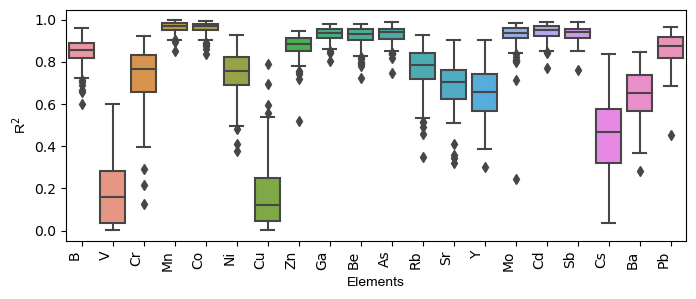

In [11]:
### Making a plot to have a view on the R2 score for each predicted element
fig, ax = plt.subplots(1,1, figsize=(8,3))
sns.boxplot(data=df_melted, x='Element', y='R_squared')
plt.xlabel('Elements', fontname = "Arial", fontsize=10)
plt.ylabel('R$^2$', fontname = "Arial", fontsize=10)
plt.xticks(rotation=90, ha='right')
plt.show()